# Rough

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib widget

In [129]:
import pandas as pd

import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px


from plots2.fns import (
    standard_layout,
    corner_annotations_colwise,
    corner_annotations_rowwise,
    get_text_annotation
)

# from poly2.utils import get_dist_mean, edge_values
from poly2.run import no_joblib_simulations_run, no_joblib_multiple_run
from poly2.config import Config, ConfigMixture

In [32]:
cs = Config(
    type='single',
    n_k=500,
    n_l=50,
    sprays=[2],
    host_on=[False],
)

CONFIG
------
I0s = 0.00985703, 0.00985703, 0.00985703, 0.00985703, 0.009...
betas = 0.00789543, 0.00789543, 0.00789543, 0.00789543, 0.007...
decay_rate = None
fungicide_mixture = False
host_on = False
k_b = 0.8156344734666119
k_mu = 9.590528108612816
l_b = 6.585357214619326
l_mu = 0.8089358816813786
mutation_proportion = 1.234375e-05
mutation_scale_fung = 0.0019190807543534802
mutation_scale_host = 0.0019190807543534802
n_iterations = None
n_k = 500
n_l = 50
n_years = 15
replace_cultivars = None
sprays = 2
type = single



In [33]:
r1 = no_joblib_simulations_run(cs)

running simulation


In [41]:
cm = Config(
    type='multi',
    n_k=500,
    n_l=50,
    sprays=[2],
    host_on=[False],
    n_iterations=2,
)

CONFIG
------
I0s = 0.00985703, 0.00985703, 0.00985703, 0.00985703, 0.009...
beta_multi = 0.00755103, 0.00871998, 0.00706794, ..., 0.00685062, 0...
decay_rate = None
fungicide_mixture = False
host_on = False
k_b = 0.8156344734666119
k_mu = 9.590528108612816
l_b = 6.585357214619326
l_mu = 0.8089358816813786
mutation_proportion = 1.234375e-05
mutation_scale_fung = 0.0019190807543534802
mutation_scale_host = 0.0019190807543534802
n_iterations = 2
n_k = 500
n_l = 50
n_years = 15
replace_cultivars = None
sprays = 2
type = multi



In [42]:
r2 = no_joblib_multiple_run(cm)

running multiple runs


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:32<00:00, 16.12s/it]


In [142]:
cmix = ConfigMixture(
    dose_A=0.75,
    dose_B=0.5,
    sprays=[2],
    verbose=False
)

cmix.A_mu = 4
cmix.B_mu = 5

cmix.print_repr()

CONFIG
------
A_b = 0.8156344734666119
A_mu = 4
B_b = 0.8156344734666119
B_mu = 5
I0s = [0.00985703, 0.00985703, 0.00985703, 0.00985 ...
betas = [0.00789543, 0.00789543, 0.00789543, 0.007 ...
decay_rate_A = None
decay_rate_B = None
doses_A = [0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7 ...
doses_B = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...
fungicide_mixture = True
host_on = [False]
mutation_proportion = 1.234375e-05
mutation_scale_fung = 0.0019190807543534802
mutation_scale_host = 0.0019190807543534802
n_k = 50
n_years = 15
sprays = [2]
type = single



In [143]:
%%time
rm = no_joblib_simulations_run(cmix)

running simulation
Wall time: 8.43 s


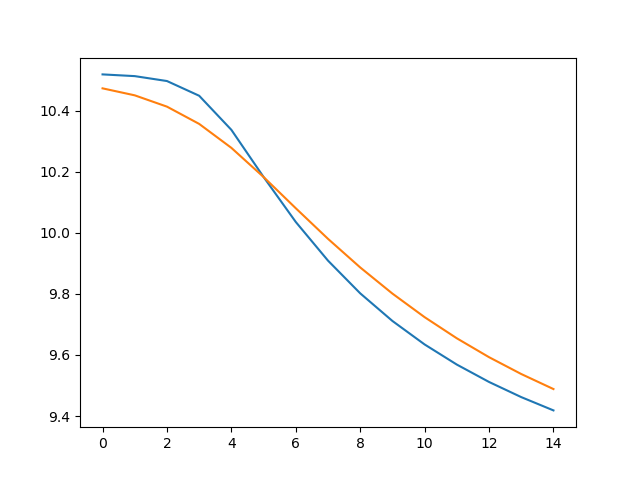

In [144]:
f, ax = plt.subplots()

ax.plot(r1['spray_2_host_N']['yield_vec'])
ax.plot(rm['spray_2_host_N']['yield_vec'])

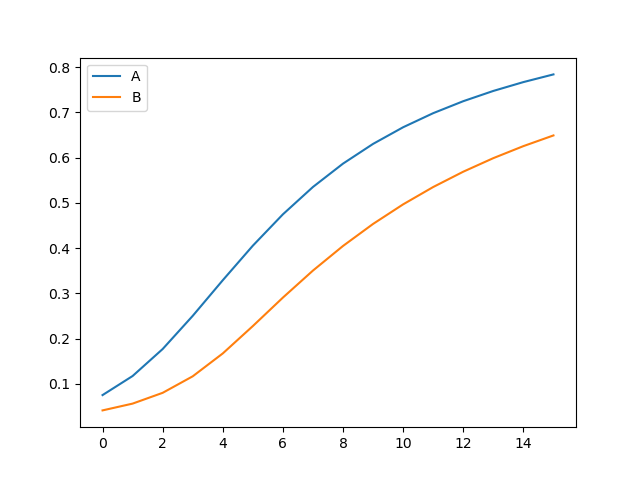

In [145]:
f, ax = plt.subplots()

rm2 = rm['spray_2_host_N']

ax.plot(rm2['fung_mean_A'], label='A')
ax.plot(rm2['fung_mean_B'], label='B')

ax.legend()